In [ ]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Weakly Supervised Anomaly Detection with Implicit Guidance

This tutorial illustrates how to use MONAI Generative Models for training a 2D anomaly detection using DDIMs [1]. By leveraging recent advances in generative diffusion probabilistic models, we synthesize counterfactuals of "How would a patient appear if X pathology was not present?". The difference image between the observed patient state and the healthy counterfactual can be used for inferring the location of pathology. We generate counterfactuals that correspond to the minimal change of the input such that it is transformed to healthy domain. We create these counterfactual diffusion models by manipulating the generation process with implicit guidance.

In summary, the tutorial will cover the following:
1. Loading and preprocessing a dataset (we extract the brain MRI dataset 2D slices from 3D volumes from the BraTS dataset)
2. Training a 2D diffusion model
3. Anomaly detection with the trained model

This method results in anomaly heatmaps. It is weakly supervised. The information about labels is not fed to the model as segmentation masks but as a scalar signal (is there an anomaly or not), which is used to guide the diffusion process.

During inference, the model generates a counterfactual image, which is then compared to the original image. The difference between the two images is used to generate an anomaly heatmap.

[1] - Sanchez et al. [What is Healthy? Generative Counterfactual Diffusion for Lesion Localization](https://arxiv.org/abs/2207.12268). DGM 4 MICCAI 2022

## Setup imports

In [9]:
import os
import tempfile
import time
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import sys
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm


from generative.inferers import DiffusionInferer
from generative.networks.nets.diffusion_model_unet import DiffusionModelUNet
from generative.networks.schedulers.ddim import DDIMScheduler

torch.multiprocessing.set_sharing_strategy("file_system")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

print_config()

MONAI version: 1.1.0
Numpy version: 1.23.5
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /remote/rds/users/s2086085/miniconda3/envs/pytorch_monai/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 5.0.1
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.12.0
gdown version: 4.6.4
TorchVision version: 0.14.1+cu117
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.4
pandas version: 1.5.3
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.1.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory

## Set deterministic training for reproducibility

In [4]:
set_determinism(42)

## Setup BRATS Dataset  - Transforms for extracting 2D slices from 3D volumes

We now download the BraTS dataset and extract the 2D slices from the 3D volumes. The `slice_label` is used to indicate whether the slice contains an anomaly or not.

Here we use transforms to augment the training dataset, as usual:

1. `LoadImaged` loads the brain images from files.
2. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
3.  The first `Lambdad` transform chooses the first channel of the image, which is the T1-weighted image.
4. `Spacingd` resamples the image to the specified voxel spacing, we use 3,3,2 mm to match the original paper.
5. `ScaleIntensityRangePercentilesd` Apply range scaling to a numpy array based on the intensity distribution of the input. Transform is very common with MRI images.
6. `RandSpatialCropd` randomly crop out a 2D patch from the 3D image.
6. The last `Lambdad` transform obtains `slice_label` by summing up the label to have a single scalar value (healthy `=1` or not `=2` ).

In [5]:
channel = 0  # 0 = Flair
assert channel in [0, 1, 2, 3], "Choose a valid channel"

train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.EnsureChannelFirstd(keys=["image", "label"]),
        transforms.Lambdad(keys=["image"], func=lambda x: x[channel, :, :, :]),
        transforms.AddChanneld(keys=["image"]),
        transforms.EnsureTyped(keys=["image", "label"]),
        transforms.Orientationd(keys=["image", "label"], axcodes="RAS"),
        transforms.Spacingd(keys=["image", "label"], pixdim=(3.0, 3.0, 2.0), mode=("bilinear", "nearest")),
        transforms.CenterSpatialCropd(keys=["image", "label"], roi_size=(64, 64, 44)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
        transforms.RandSpatialCropd(keys=["image", "label"], roi_size=(64, 64, 1), random_size=False),
        transforms.Lambdad(keys=["image", "label"], func=lambda x: x.squeeze(-1)),
        transforms.CopyItemsd(keys=["label"], times=1, names=["slice_label"]),
        transforms.Lambdad(keys=["slice_label"], func=lambda x: 2.0 if x.sum() > 0 else 1.0),
    ]
)

<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.


### Load Training and Validation Datasets

In [6]:
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="training",
    cache_rate=1.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=False,  # Set download to True if the dataset hasnt been downloaded yet
    seed=0,
    transform=train_transforms,
)
print(f"Length of training data: {len(train_ds)}")
print(f'Train image shape {train_ds[0]["image"].shape}')

val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="validation",
    cache_rate=1.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=False,  # Set download to True if the dataset hasnt been downloaded yet
    seed=0,
    transform=train_transforms,
)
print(f"Length of training data: {len(val_ds)}")
print(f'Validation Image shape {val_ds[0]["image"].shape}')

Loading dataset: 100%|██████████| 388/388 [02:41<00:00,  2.40it/s]


Lenght of training data: 388
Train image shape torch.Size([1, 64, 64])


Loading dataset: 100%|██████████| 96/96 [00:39<00:00,  2.42it/s]

Lenght of training data: 96
Validation Image shape torch.Size([1, 64, 64])


## Define network, scheduler, optimizer, and inferer

At this step, we instantiate the MONAI components to create a DDIM, the UNET with conditioning, the noise scheduler, and the inferer used for training and sampling. We are using
the deterministic DDIM scheduler containing 1000 timesteps, and a 2D UNET with attention mechanisms.

The `attention` mechanism is essential for ensuring good conditioning and images manipulation here.

An `embedding layer`, which is also optimised during training, is used in the original work because it was empirically shown to improve conditioning compared to a single scalar information.


In [7]:
device = torch.device("cuda")
embedding_dimension = 64
model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(64, 64, 64),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=16,
    with_conditioning=True,
    cross_attention_dim=embedding_dimension,
).to(device)
embed = torch.nn.Embedding(num_embeddings=3, embedding_dim=embedding_dimension, padding_idx=0).to(device)

scheduler = DDIMScheduler(num_train_timesteps=1000)
optimizer = torch.optim.Adam(params=list(model.parameters()) + list(embed.parameters()), lr=1e-5)

inferer = DiffusionInferer(scheduler)

## Training a diffusion model with classifier-free guidance

Train Loss 0.8078, Interval Loss 0.9115, Interval Loss Val 0.8100
Train Loss 0.6174, Interval Loss 0.7103, Interval Loss Val 0.6154
Train Loss 0.4603, Interval Loss 0.5313, Interval Loss Val 0.4571
Train Loss 0.3323, Interval Loss 0.3887, Interval Loss Val 0.3288
Train Loss 0.2358, Interval Loss 0.2822, Interval Loss Val 0.2356
Train Loss 0.1771, Interval Loss 0.2034, Interval Loss Val 0.1660
Train Loss 0.1237, Interval Loss 0.1467, Interval Loss Val 0.1185
Train Loss 0.0802, Interval Loss 0.1054, Interval Loss Val 0.0855
Train Loss 0.0731, Interval Loss 0.0770, Interval Loss Val 0.0699
Train Loss 0.0528, Interval Loss 0.0570, Interval Loss Val 0.0512
Train Loss 0.0383, Interval Loss 0.0434, Interval Loss Val 0.0311
Train Loss 0.0268, Interval Loss 0.0343, Interval Loss Val 0.0483
Train Loss 0.0330, Interval Loss 0.0292, Interval Loss Val 0.0255
Train Loss 0.0359, Interval Loss 0.0250, Interval Loss Val 0.0293
Train Loss 0.0235, Interval Loss 0.0233, Interval Loss Val 0.0318
Train Loss

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


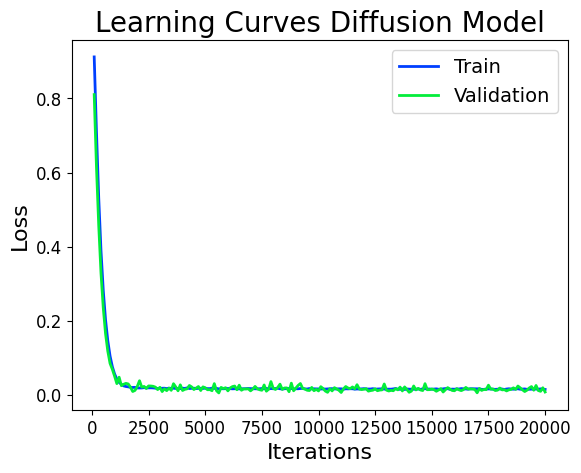

In [10]:
condition_dropout = 0.15
n_iterations = 2e4
batch_size = 64
val_interval = 100
iter_loss_list = []
val_iter_loss_list = []
iterations = []
iteration = 0
iter_loss = 0

train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True, persistent_workers=True
)
val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True, persistent_workers=True
)

scaler = GradScaler()
total_start = time.time()

while iteration < n_iterations:
    for batch in train_loader:
        iteration += 1
        model.train()
        images, classes = batch["image"].to(device), batch["slice_label"].to(device)
        # 15% of the time, class conditioning dropout
        classes = classes * (torch.rand_like(classes) > condition_dropout)
        # cross attention expects shape [batch size, sequence length, channels]
        class_embedding = embed(classes.long().to(device)).unsqueeze(1)
        optimizer.zero_grad(set_to_none=True)
        # pick a random time step t
        timesteps = torch.randint(0, 1000, (len(images),)).to(device)

        with autocast(enabled=True):
            # Generate random noise
            noise = torch.randn_like(images).to(device)
            # Get model prediction
            noise_pred = inferer(
                inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps, condition=class_embedding
            )
            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        iter_loss += loss.item()
        sys.stdout.write(f"Iteration {iteration}/{n_iterations} - train Loss {loss.item():.4f}" + "\r")
        sys.stdout.flush()

        if (iteration) % val_interval == 0:
            model.eval()
            val_iter_loss = 0
            for val_step, val_batch in enumerate(val_loader):
                images, classes = val_batch["image"].to(device), val_batch["slice_label"].to(device)
                # cross attention expects shape [batch size, sequence length, channels]
                class_embedding = embed(classes.long().to(device)).unsqueeze(1)
                timesteps = torch.randint(0, 1000, (len(images),)).to(device)
                with torch.no_grad():
                    with autocast(enabled=True):
                        noise = torch.randn_like(images).to(device)
                        noise_pred = inferer(
                            inputs=images,
                            diffusion_model=model,
                            noise=noise,
                            timesteps=timesteps,
                            condition=class_embedding,
                        )
                        val_loss = F.mse_loss(noise_pred.float(), noise.float())
                val_iter_loss += val_loss.item()
            iter_loss_list.append(iter_loss / val_interval)
            val_iter_loss_list.append(val_iter_loss / (val_step + 1))
            iterations.append(iteration)
            iter_loss = 0
            print(
                f"Train Loss {loss.item():.4f}, Interval Loss {iter_loss_list[-1]:.4f}, Interval Loss Val {val_iter_loss_list[-1]:.4f}"
            )


total_time = time.time() - total_start

print(f"train diffusion completed, total time: {total_time}.")

plt.style.use("seaborn-bright")
plt.title("Learning Curves Diffusion Model", fontsize=20)
plt.plot(iterations, iter_loss_list, color="C0", linewidth=2.0, label="Train")
plt.plot(
    iterations, val_iter_loss_list, color="C1", linewidth=2.0, label="Validation"
)  # np.linspace(1, n_iterations, len(val_iter_loss_list))
plt.yticks(fontsize=12), plt.xticks(fontsize=12)
plt.xlabel("Iterations", fontsize=16), plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

## Generate synthetic data
(Only for verifying the model and classifier guidance is working)

100%|██████████| 100/100 [00:02<00:00, 43.69it/s]


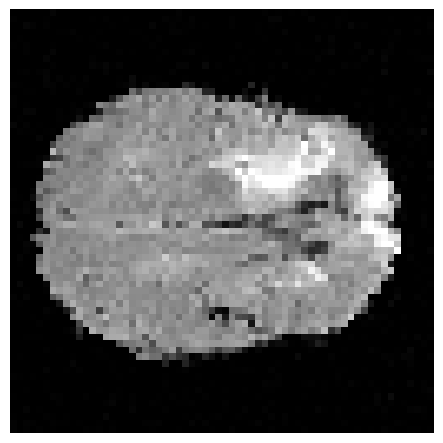

In [14]:
model.eval()
scheduler.clip_sample = True
guidance_scale = 3
conditioning = torch.cat([torch.zeros(1).long(), 2 * torch.ones(1).long()], dim=0).to(
    device
)  # 2*torch.ones(1).long() is the class label for the UNHEALTHY (tumor) class
class_embedding = embed(conditioning).unsqueeze(
    1
)  # cross attention expects shape [batch size, sequence length, channels]
noise = torch.randn((1, 1, 64, 64))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=100)
progress_bar = tqdm(scheduler.timesteps)
for t in progress_bar:
    with autocast(enabled=True):
        with torch.no_grad():
            noise_input = torch.cat([noise] * 2)
            model_output = model(noise_input, timesteps=torch.Tensor((t,)).to(noise.device), context=class_embedding)
            noise_pred_uncond, noise_pred_text = model_output.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    noise, _ = scheduler.step(noise_pred, t, noise)

plt.style.use("default")
plt.imshow(noise[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

# Image-to-Image Translation to a Healthy Subject
We pick a diseased subject of the validation set as input image. We want to translate it to its healthy reconstruction.

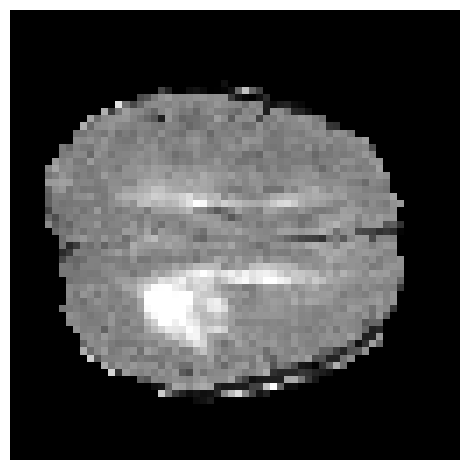

input label:  tensor(2., dtype=torch.float64)


In [15]:

idx_unhealthy = np.argwhere(val_batch["slice_label"].numpy() == 2).squeeze()

idx = idx_unhealthy[4]  # Pick a random slice of the validation set to be transformed
inputting = val_batch["image"][idx]  # Pick an input slice of the validation set to be transformed
inputlabel = val_batch["slice_label"][idx]  # Check whether it is healthy or diseased

plt.figure("input" + str(inputlabel))
plt.imshow(inputting[0], vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

model.eval()
print("input label: ", inputlabel)


### The image-to-image translation has two steps

1. Encoding the input image into a latent space with the reversed DDIM sampling scheme
2. Sampling from the latent space using gradient guidance towards the desired class label `y=1` (healthy)

In order to sample using gradient guidance, we first need to encode the input image in noise by using the reversed DDIM sampling scheme.
We define the number of steps in the noising and denoising process by `L`.

In [22]:
model.eval()

guidance_scale = 3.0
total_timesteps = 500
latent_space_depth = int(total_timesteps * 0.25)

current_img = inputting[None, ...].to(device)
scheduler.set_timesteps(num_inference_steps=total_timesteps)

## Encoding

scheduler.clip_sample = False
class_embedding = embed(torch.zeros(1).long().to(device)).unsqueeze(1)
progress_bar = tqdm(range(latent_space_depth))
for i in progress_bar:  # go through the noising process
    t = i
    with torch.no_grad():
        model_output = model(current_img, timesteps=torch.Tensor((t,)).to(current_img.device), context=class_embedding)
    current_img, _ = scheduler.reversed_step(model_output, t, current_img)
    progress_bar.set_postfix({"timestep input": t})

latent_img = current_img

## Decoding
conditioning = torch.cat([torch.zeros(1).long(), torch.ones(1).long()], dim=0).to(device)
class_embedding = embed(conditioning).unsqueeze(1)

progress_bar = tqdm(range(latent_space_depth))
for i in progress_bar:  # go through the denoising process
    t = latent_space_depth - i
    current_img_double = torch.cat([current_img] * 2)
    with torch.no_grad():
        model_output = model(
            current_img_double, timesteps=torch.Tensor([t, t]).to(current_img.device), context=class_embedding
        )
    noise_pred_uncond, noise_pred_text = model_output.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    current_img, _ = scheduler.step(noise_pred, t, current_img)
    progress_bar.set_postfix({"timestep input": t})
    torch.cuda.empty_cache()

100%|██████████| 125/125 [00:05<00:00, 24.68it/s, timestep input=1] 


### Visualize anomaly map

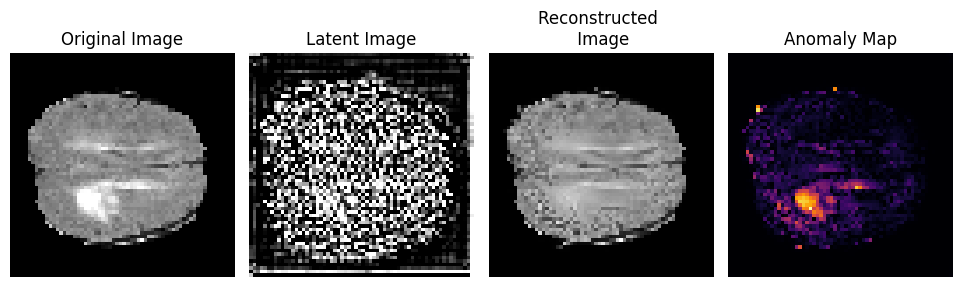

In [23]:
def visualize(img):
    _min = img.min()
    _max = img.max()
    normalized_img = (img - _min) / (_max - _min)
    return normalized_img


diff = abs(inputting.cpu() - current_img[0].cpu()).detach().numpy()
row = 4
plt.style.use("default")

fig = plt.figure(figsize=(10, 30))

ax = plt.subplot(1, row, 2)
ax.imshow(latent_img[0, 0].cpu().detach().numpy(), vmin=0, vmax=1, cmap="gray")
ax.set_title("Latent Image"), plt.tight_layout(), plt.axis("off")

ax = plt.subplot(1, row, 3)
ax.imshow(current_img[0, 0].cpu().detach().numpy(), vmin=0, vmax=1, cmap="gray")
ax.set_title("Reconstructed \n Image"), plt.tight_layout(), plt.axis("off")


ax = plt.subplot(1, row, 4)
ax.imshow(diff[0], cmap="inferno")
ax.set_title("Anomaly Map"), plt.tight_layout(), plt.axis("off")

ax = plt.subplot(1, row, 1)
ax.imshow(inputting[0], vmin=0, vmax=1, cmap="gray")
ax.set_title("Original Image"), plt.tight_layout(), plt.axis("off")
plt.show()